# Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers
import time
# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


Using TensorFlow backend.


## Load Data

In [28]:
#
# generate data from time series
#
def generate_data(dataset, D= 1, T = 201, target='rank'):
    # simple input is 18 cars with all 201 records sorted
    
    if dataset.shape[0] != 18 * T:
        print('error input shape:', dataset.shape)
        return None
        
    x = np.array(dataset.time_diff).reshape((18,-1))
    if target == 'rank':
        y = np.array(dataset.rank_diff).reshape((18,-1))
    elif target =='time':
        y = np.array(dataset.time_diff).reshape((18,-1))
    else:
        print('error in target setting as', target)
        return None
    
    retlen = T - D
    X_train = x[:, :retlen].reshape((18, retlen, 1))
    y_train = y[:, D:].reshape((18, retlen, 1))
    return X_train,y_train

def plot_examples(X,y,ypreds=None,nm_ypreds=None):
    fig = plt.figure(figsize=(16,10))
    fig.subplots_adjust(hspace = 0.32,wspace = 0.15)
    count = 1
    n_ts = X.shape[0]
    num_per_row = 4 if n_ts > 4 else 1
    for irow in range(n_ts):
        ax = fig.add_subplot(int(n_ts+num_per_row -1)/num_per_row,num_per_row,count)
        #ax.set_ylim(-0.5,0.5)
        ax.plot(X[irow,:,0],"--",label="x1")
        ax.plot(y[irow,:,:],marker='.',label="y",linewidth=3,alpha = 0.5)
        ax.set_title("{:}th time series sample".format(irow))
        if ypreds is not None:
            for ypred,nm in zip(ypreds,nm_ypreds):
                ax.plot(ypred[irow,:,:],marker='.',label=nm)   
        count += 1
    plt.legend()
    plt.show()
    if ypreds is not None:
        for y_pred, nm_ypred in zip(ypreds,nm_ypreds):
            loss = np.mean( (y_pred[:,D:,:].flatten() - y[:,D:,:].flatten())**2)
            print("The final validation loss of {} is {:7.6f}".format(
                nm_ypred,loss))


In [21]:
#
# baseline works to predict the rankdiff or timediff
# it's a standard time series prediction
# 
dataset = pd.read_csv('completed_laps_diff.csv')
dataset.info(verbose=True)
print('dataset shape', dataset.shape)
# predict next lap 
D = 5 
T = 201
#X, y = generate_data(dataset, D=D,T=T, target='rank')
X, y = generate_data(dataset, D=D,T=T, target='time')

#prop_train = 0.8
#ntrain = int(X.shape[0]*prop_train)
#X_train, X_val = X[:ntrain], X[ntrain:]
#y_train, y_val = y[:ntrain], y[ntrain:]

ntrain = 12
nval = 3
ntest = 3

X_train, X_val, X_test = X[:ntrain], X[ntrain:ntrain + nval], X[ntrain + nval:]
y_train, y_val, y_test = y[:ntrain], y[ntrain:ntrain + nval], y[ntrain + nval:]

print('x_train, shape=', X_train.shape)
print('y_train, shape=', y_train.shape)

w = np.zeros(y.shape[:2])
w[:,D:] = 1 
w_train = w
w_train, w_val = w[:ntrain], w[ntrain:ntrain + nval]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618 entries, 0 to 3617
Data columns (total 7 columns):
Unnamed: 0        3618 non-null int64
car_number        3618 non-null int64
completed_laps    3618 non-null int64
rank              3618 non-null int64
elapsed_time      3618 non-null float64
rank_diff         3618 non-null float64
time_diff         3618 non-null float64
dtypes: float64(3), int64(4)
memory usage: 197.9 KB
dataset shape (3618, 7)
x_train, shape= (12, 196, 1)
y_train, shape= (12, 196, 1)


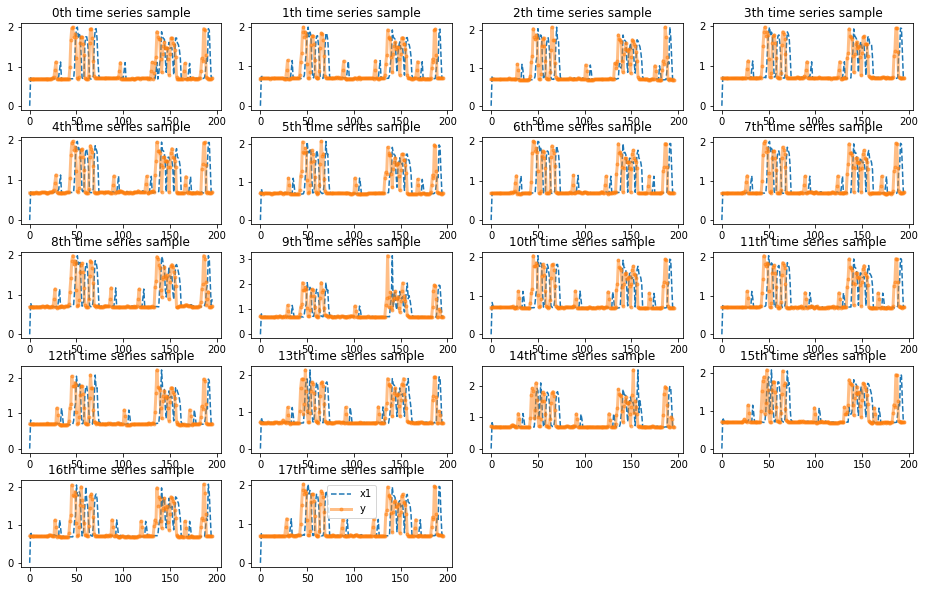

In [32]:
plot_examples(X,y,ypreds=None,nm_ypreds=None)

## Define model

In [18]:
#
# https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html
#
def define_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="rmsprop")
    return(model,(inp,rnn,dens))

In [19]:
hunits = 64
model_stateless, _ = define_model(
                    hidden_neurons = hunits,
                    len_ts = X_train.shape[1])
model_stateless.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 196, 1)            0         
_________________________________________________________________
RNN (LSTM)                   (None, 196, 64)           16896     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 196, 1)            65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


### train for 500 epochs


Train on 12 samples, validate on 3 samples
Epoch 1/500
 - 0s - loss: 0.0074 - val_loss: 0.0190
Epoch 2/500
 - 0s - loss: 0.0072 - val_loss: 0.0191
Epoch 3/500
 - 0s - loss: 0.0071 - val_loss: 0.0189
Epoch 4/500
 - 0s - loss: 0.0072 - val_loss: 0.0199
Epoch 5/500
 - 0s - loss: 0.0075 - val_loss: 0.0193
Epoch 6/500
 - 0s - loss: 0.0080 - val_loss: 0.0217
Epoch 7/500
 - 0s - loss: 0.0089 - val_loss: 0.0195
Epoch 8/500
 - 0s - loss: 0.0092 - val_loss: 0.0218
Epoch 9/500
 - 0s - loss: 0.0088 - val_loss: 0.0210
Epoch 10/500
 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 11/500
 - 0s - loss: 0.0110 - val_loss: 0.0226
Epoch 12/500
 - 0s - loss: 0.0086 - val_loss: 0.0174
Epoch 13/500
 - 0s - loss: 0.0079 - val_loss: 0.0252
Epoch 14/500
 - 0s - loss: 0.0097 - val_loss: 0.0202
Epoch 15/500
 - 0s - loss: 0.0130 - val_loss: 0.0209
Epoch 16/500
 - 0s - loss: 0.0085 - val_loss: 0.0181
Epoch 17/500
 - 0s - loss: 0.0076 - val_loss: 0.0197
Epoch 18/500
 - 0s - loss: 0.0071 - val_loss: 0.0181
Epoch 19/500

Epoch 154/500
 - 0s - loss: 0.0066 - val_loss: 0.0184
Epoch 155/500
 - 0s - loss: 0.0068 - val_loss: 0.0200
Epoch 156/500
 - 0s - loss: 0.0073 - val_loss: 0.0188
Epoch 157/500
 - 0s - loss: 0.0078 - val_loss: 0.0216
Epoch 158/500
 - 0s - loss: 0.0087 - val_loss: 0.0195
Epoch 159/500
 - 0s - loss: 0.0087 - val_loss: 0.0216
Epoch 160/500
 - 0s - loss: 0.0088 - val_loss: 0.0193
Epoch 161/500
 - 0s - loss: 0.0084 - val_loss: 0.0210
Epoch 162/500
 - 0s - loss: 0.0083 - val_loss: 0.0192
Epoch 163/500
 - 0s - loss: 0.0081 - val_loss: 0.0211
Epoch 164/500
 - 0s - loss: 0.0082 - val_loss: 0.0182
Epoch 165/500
 - 0s - loss: 0.0073 - val_loss: 0.0206
Epoch 166/500
 - 0s - loss: 0.0072 - val_loss: 0.0175
Epoch 167/500
 - 0s - loss: 0.0075 - val_loss: 0.0213
Epoch 168/500
 - 0s - loss: 0.0075 - val_loss: 0.0178
Epoch 169/500
 - 0s - loss: 0.0078 - val_loss: 0.0218
Epoch 170/500
 - 0s - loss: 0.0087 - val_loss: 0.0219
Epoch 171/500
 - 0s - loss: 0.0087 - val_loss: 0.0212
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.0088 - val_loss: 0.0237
Epoch 307/500
 - 0s - loss: 0.0106 - val_loss: 0.0194
Epoch 308/500
 - 0s - loss: 0.0105 - val_loss: 0.0217
Epoch 309/500
 - 0s - loss: 0.0090 - val_loss: 0.0207
Epoch 310/500
 - 0s - loss: 0.0076 - val_loss: 0.0209
Epoch 311/500
 - 0s - loss: 0.0074 - val_loss: 0.0171
Epoch 312/500
 - 0s - loss: 0.0090 - val_loss: 0.0201
Epoch 313/500
 - 0s - loss: 0.0069 - val_loss: 0.0184
Epoch 314/500
 - 0s - loss: 0.0069 - val_loss: 0.0203
Epoch 315/500
 - 0s - loss: 0.0070 - val_loss: 0.0182
Epoch 316/500
 - 0s - loss: 0.0071 - val_loss: 0.0202
Epoch 317/500
 - 0s - loss: 0.0077 - val_loss: 0.0207
Epoch 318/500
 - 0s - loss: 0.0077 - val_loss: 0.0234
Epoch 319/500
 - 0s - loss: 0.0097 - val_loss: 0.0214
Epoch 320/500
 - 0s - loss: 0.0121 - val_loss: 0.0206
Epoch 321/500
 - 0s - loss: 0.0094 - val_loss: 0.0225
Epoch 322/500
 - 0s - loss: 0.0078 - val_loss: 0.0169
Epoch 323/500
 - 0s - loss: 0.0079 - val_loss: 0.0210
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.0089 - val_loss: 0.0185
Epoch 459/500
 - 0s - loss: 0.0081 - val_loss: 0.0207
Epoch 460/500
 - 0s - loss: 0.0078 - val_loss: 0.0183
Epoch 461/500
 - 0s - loss: 0.0078 - val_loss: 0.0205
Epoch 462/500
 - 0s - loss: 0.0077 - val_loss: 0.0184
Epoch 463/500
 - 0s - loss: 0.0075 - val_loss: 0.0202
Epoch 464/500
 - 0s - loss: 0.0075 - val_loss: 0.0188
Epoch 465/500
 - 0s - loss: 0.0076 - val_loss: 0.0201
Epoch 466/500
 - 0s - loss: 0.0076 - val_loss: 0.0194
Epoch 467/500
 - 0s - loss: 0.0077 - val_loss: 0.0199
Epoch 468/500
 - 0s - loss: 0.0076 - val_loss: 0.0197
Epoch 469/500
 - 0s - loss: 0.0075 - val_loss: 0.0195
Epoch 470/500
 - 0s - loss: 0.0074 - val_loss: 0.0196
Epoch 471/500
 - 0s - loss: 0.0073 - val_loss: 0.0196
Epoch 472/500
 - 0s - loss: 0.0078 - val_loss: 0.0221
Epoch 473/500
 - 0s - loss: 0.0095 - val_loss: 0.0278
Epoch 474/500
 - 0s - loss: 0.0119 - val_loss: 0.0189
Epoch 475/500
 - 0s - loss: 0.0131 - val_loss: 0.0199
Epoch 476/500
 - 0s - loss: 

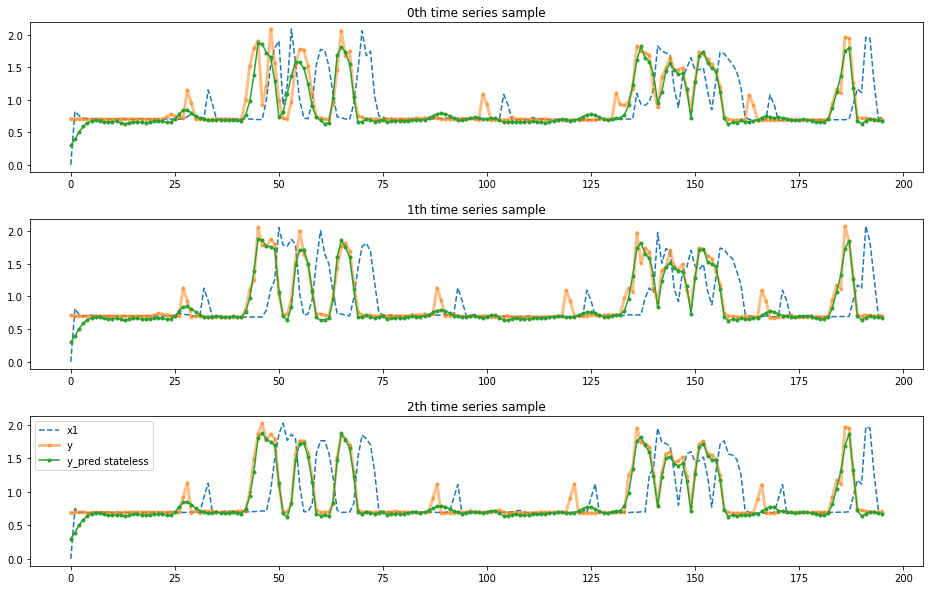

The final validation loss of y_pred stateless is 0.012460


In [35]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=18,
                             epochs=500,
                             verbose=2,
                             sample_weight=w_train,
                             validation_data=(X_val,y_val,w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))
y_pred_stateless = model_stateless.predict(X_test)
plot_examples(X_test,y_test,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])

### train for 2000 epochs
It is amazing to see the capacity of the model, which predicts the pikes of crashes ''accurately''.
However, the performance goes worse in the cases of pitstops. They are totally ignored.
Overfitting must occur here.
To verify that, let''s train on data of a different event, such as train on 2017 and then test on 2018. 
Another idea is to modify the loss funtion to emphysize on pitstops.



Time Took :6.72 min


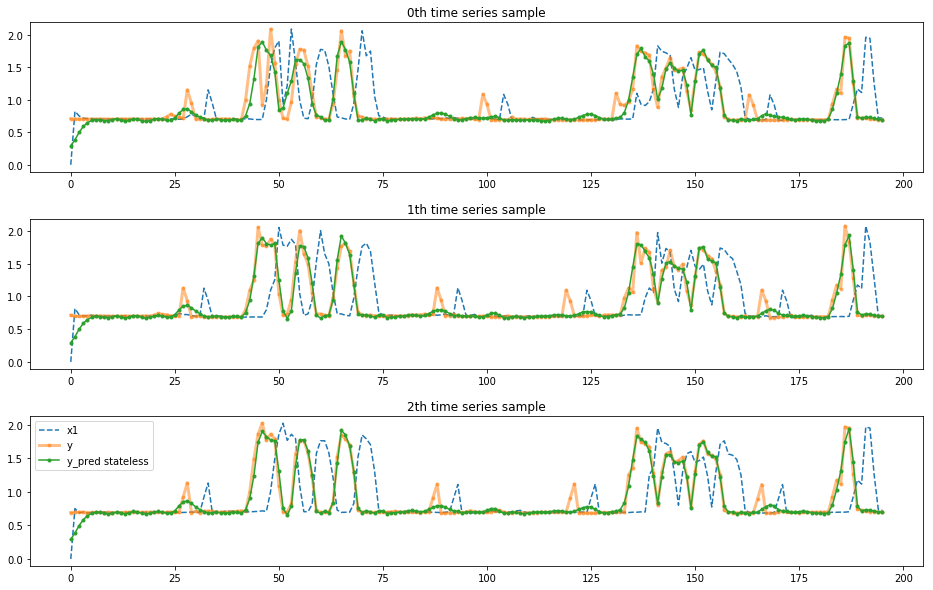

The final validation loss of y_pred stateless is 0.011606


In [33]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=18,
                             epochs=2000,
                             verbose=2,
                             sample_weight=w_train,
                             validation_data=(X_val,y_val,w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))
y_pred_stateless = model_stateless.predict(X_test)
plot_examples(X_test,y_test,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])